In [1]:
import os
os.chdir('E:/sandy/drop out ratio')

In [3]:
#importing data set
import pandas as pd
df = pd.read_csv('MOOC_Visual.csv')

In [4]:
df['startdate'] = pd.to_datetime(df['startdate'])
df['enddate'] = pd.to_datetime(df['enddate'])

df['start_year'] = df['startdate'].dt.year
df['start_month'] = df['startdate'].dt.month
df['end_year'] = df['enddate'].dt.year
df['end_month'] = df['enddate'].dt.month

In [5]:
#dropping startdate and enddate column 
df.drop(['startdate', 'enddate'],axis = 1,inplace = True)

## HANDLING imalanced dataset

In [6]:
#usin SMOTETOMEK technique 
from imblearn.combine import SMOTETomek
from collections import Counter 
os = SMOTETomek(0.5)
X,y = os.fit_sample(df.drop(['dropout_prob','enrollment_id'],axis = 1),df['dropout_prob'])
print(Counter(y))

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


Counter({1: 56156, 0: 27456})


## HANDLING FEATURES

In [7]:
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()
X = stand.fit_transform(X)

In [ ]:
#DEALIN OUTLIERS
x = 'user_enroll'
#Figure = df.boxplot(column = x)
upper_bound2 = df[x].mean()+3*df[x].std()
lower_bound2 = df[x].mean()-3*df[x].std()

#IQR

IQR = df[x].quantile(0.75)-df[x].quantile(0.25)
lower1 = df[x].quantile(0.25)-3*(IQR)
upper1 = df[x].quantile(0.75)+3*(IQR)


In [ ]:
import numpy as np

X.loc[X['navigate']> 46.25,'navigate'] = 46.25
X.loc[X['discussion']> 10,'discussion'] = 10
X.loc[X['access']> 101,'access'] = 101
X.loc[X['page_close']> 36,'page_close'] = 36
X.loc[X['problem']> 24,'problem'] = 24
X.loc[X['video']> 24,'video'] = 24
X.loc[X['wiki']> 4,'wiki'] = 4
X.loc[X['proccess_period']> 39.72,'proccess_period'] = 39.72
X.loc[X['present_days']> 9,'present_days'] = 9
X.loc[X['effective_time']> 15,'effective_time'] = 15
X.loc[X['user_enroll']> 9,'user_enroll'] = 9
X['start_year'] = np.where(X['start_year']==2014,1,0)
X['end_year'] = np.where(X['end_year']==2014,1,0)

## FEATURE SELECTION

In [ ]:
# Scoring features on basis of Importance using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesClassifier
selection = ExtraTreesClassifier()
selection.fit(X, y)

In [ ]:
#plot graph of feature importances for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [ ]:
feat_importances.nlargest(20).index

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
top_features = SelectKBest(score_func = chi2, k = 20)
ordered_feature = top_features.fit(X,y)
df_score = pd.DataFrame(ordered_feature.scores_, columns = ["scores"])
df_columns = pd.DataFrame(X.columns)
features_rank = pd.concat([df_columns,df_score],axis = 1)
features_rank.columns = ['Features','scores']
features_rank['scores'].sort()

In [8]:
#SPLITTIN DATA IN TEST AND TRAIN
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## XGBOOST ALGO with HYPERPARAMETER TUNING

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate  
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import numpy as np
from sklearn.model_selection import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [10]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['dropout_prob'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['dropout_prob'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['dropout_prob'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['dropout_prob'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [10]:
#Choose all predictors except target & IDcols
predictors = [x for x in df.columns if x not in ['dropout_prob','enrollment_id']]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


Model Report
Accuracy : 0.8859
AUC Score (Train): 0.897805


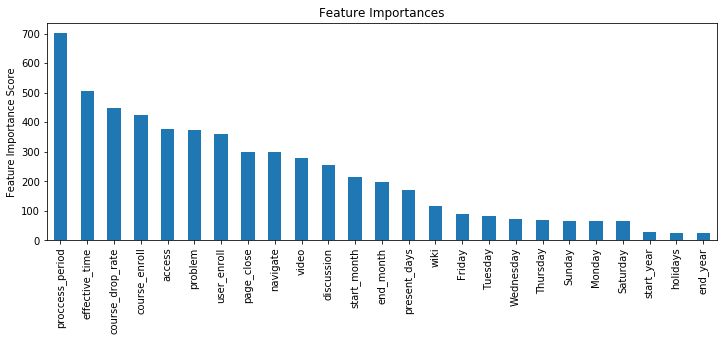

In [28]:
#intially i tried with random hperparameters and checked with original data frame
modelfit(xgb1, df, predictors)

In [14]:
y_train.value_counts()/len(y_train)

1    0.671031
0    0.328969
Name: dropout_prob, dtype: float64

In [ ]:
#Now leststart training hyperparameter on training data (upsampled data )
#startin with max depth and min_child weight

In [15]:
param_test1 = {
 'max_depth':[8,10,12,14,16,18],
 'min_child_weight':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,max_depth = 16,min_child_weight= 0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=2, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     min_child_weight=2, nthread=4,
                                     scale_pos_weight=2, seed=27,
                                     subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': [8, 10, 12, 14, 16, 18],
                         'min_child_weight': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                              0.8, 0.9, 1]},
             scoring='roc_auc')

In [16]:
gsearch1.best_params_

{'max_depth': 16, 'min_child_weight': 0.1}

In [ ]:
#Npw replacin the values of max depth and min_child weight with optimum value
#Lets train n_estimators

In [19]:
param_test2 = {'n_estimators':range(20,120,10)}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,max_depth = 16,min_child_weight= 0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=2, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=16,
                                     min_child_weight=0.1, nthread=4,
                                     scale_pos_weight=2, seed=27,
                                     subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(20, 120, 10)},
             scoring='roc_auc')

In [20]:
gsearch2.best_params_

{'n_estimators': 110}

In [ ]:
#now train gamma 

In [23]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,n_estimators = 110,max_depth = 16,min_child_weight= 0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=2, seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=16,
                                     min_child_weight=0.1, n_estimators=110,
                                     nthread=4, scale_pos_weight=2, seed=27,
                                     subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='roc_auc')

In [24]:
gsearch3.best_params_

{'gamma': 0.0}

In [ ]:
#now we will take te values of parameters we ave trained till now and then check is it giving more accuracy ten before on train data


Model Report
Accuracy : 0.9699
AUC Score (Train): 0.995101


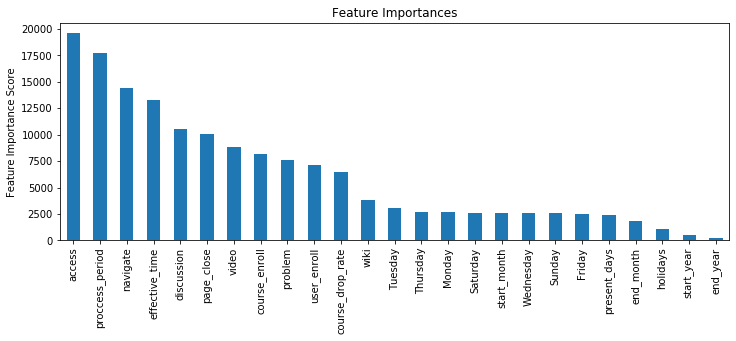

In [21]:
predictors = [x for x in df.columns if x not in ['dropout_prob','enrollment_id']]
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=16,
 min_child_weight=0.1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=2,
 seed=27)
modelfit(xgb2, df, predictors)

so what i have observed is tat initially i was getting 88% accuracy on training data now after tuning hyperparameter we get 97% accuracy so i will select these parameters for my model as on furter tuning the remaining parameters i got less accuracy

In [25]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,n_estimators = 110,max_depth = 16,min_child_weight= 0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=2, seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

C:\Users\DEEPANKAR\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=16,
                                     min_child_weight=0.1, n_estimators=110,
                                     nthread=4, scale_pos_weight=2, seed=27,
                                     subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='roc_auc')

In [26]:
gsearch4.best_params_

{'colsample_bytree': 0.9, 'subsample': 0.9}

In [ ]:
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,n_estimators = 110,max_depth = 16,min_child_weight= 0.1, gamma=0, subsample=0.9, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=2, seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

In [27]:
#Now running the model with new parameters
predictors = [x for x in df.columns if x not in ['dropout_prob','enrollment_id']]
xgb3 = XGBClassifier(learning_rate =0.1,n_estimators = 110,max_depth = 16,min_child_weight= 0.1, gamma=0, subsample=0.9, colsample_bytree=0.9,
                      objective= 'binary:logistic', nthread=4, scale_pos_weight=2, seed=27)


Model Report
Accuracy : 0.9553
AUC Score (Train): 0.983880


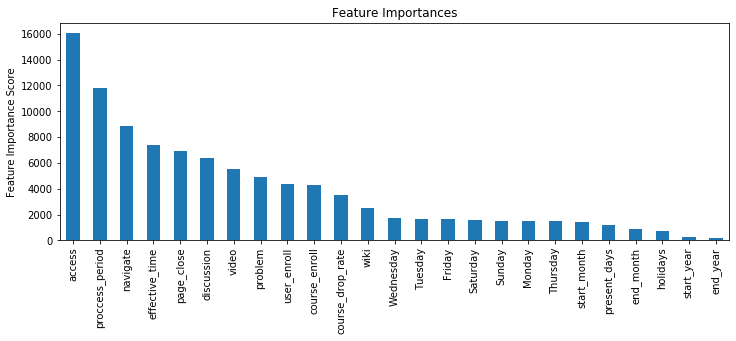

In [28]:
modelfit(xgb3, df, predictors)

So below are the final selected hyperparameters 

In [13]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=16,
 min_child_weight=0.1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=2,
 seed=27)

In [14]:
xgb2.fit(X_train,y_train)

XGBClassifier(colsample_bytree=0.8, max_depth=16, min_child_weight=0.1,
              n_estimators=1000, nthread=4, scale_pos_weight=2, seed=27,
              subsample=0.8)

In [15]:
predict = xgb2.predict(X_test)

In [16]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predict))
print(metrics.accuracy_score(y_test,predict))
print(metrics.classification_report(y_test,predict))
print(metrics.f1_score(y_test,predict))

[[ 4299  1113]
 [  642 10669]]
0.8950547150630868
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      5412
           1       0.91      0.94      0.92     11311

    accuracy                           0.90     16723
   macro avg       0.89      0.87      0.88     16723
weighted avg       0.89      0.90      0.89     16723

0.9240029446152513


So as we can see above we got nearly 90% accuracy on test data set